Yue write the code at 2023/07/21

The aim is to test the output torque and do the callibration of torque constant parameter based on spring test system

The result is to discover a unkown resistance force and I spend the othe one week to just figure out everything about the unkown resistance force(proved to be cogging force)

## connection and calibration


In [6]:
import odrive
from odrive.enums import *
import time
import math
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from termcolor import colored 
from IPython.display import clear_output
import numpy as np

def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')


def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 

def get_torque(alpha):
    # the length of the other side of the triangle (in m)
    b=3.3*0.0254
    l_ini=1.55*0.0254
    c=0.04
    K=106 #unit:N/m
    a=math.sqrt(b*b+c*c-2*b*c*math.cos(alpha))
    
    F=K*(a-l_ini)
    sinc=math.sin(alpha)*c/a
    T=F*sinc*b # unit N*m
    print('deltaL:{}mm,Force:{}N,ARM:{}mm'.format((a-l_ini)*1000,F,sinc*b*1000))
    return T




In [ ]:
get_torque(45/180*math.pi)

deltaL:22.953488092977313mm,Force:2.4330697378555954N,ARM:38.0400341589578mm


0.09255405593915335

In [36]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
print(my_drive.axis1.motor.current_control.i_gain)



finding an odrive...
Found! and the bus voltage is 21.216358184814453V
82.6633529663086
4.0


In [37]:
# calibration and enter closed control mode
# print("starting calibration...")
# my_drive.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
# while my_drive.axis1.current_state != AXIS_STATE_IDLE:
#     time.sleep(0.1)
# check(my_drive)
# my_drive.axis1.motor.config.pre_calibrated = True
# my_drive.axis1.encoder.config.pre_calibrated =True
my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
check(my_drive)

Everything is fine


t0=time.monotonic()
delta=0

while delta<10:
    delta=time.monotonic()-t0
    print(my_drive.axis1.encoder.count_in_cpr,my_drive.axis1.encoder.pos_circular)

In [46]:
my_drive.axis1.controller.input_torque = 0
check(my_drive)
print('*'*50)


Everything is fine
**************************************************


# TEST #1:
just add the torque after a peroid time and record the current&angle


In [67]:
t00=time.monotonic()
t0=time.monotonic()


cur_seq=[]
alpha_seq=[]

angle_ini=0.055*2*math.pi #unit:rad

circle_num=0
add_num=0
sample_num=0

all_cur=[]
all_angle=[]
all_time=[]
all_input=[]


dif_cur_ini=[5]
desired_cur=dif_cur_ini[0]

cur_dif_ini=[]
angle_dif_ini=[]
time_dif_ini=[]
input_dif_ini=[]

while True:

    sample_num+=1
    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured
    alpha=my_drive.axis1.encoder.pos_circular*2*math.pi-angle_ini
    all_time.append(time.monotonic()-t00)
    all_cur.append(current)
    all_angle.append(alpha)
    all_input.append(desired_cur)

    
    if sample_num%50==0:
        clear_output()
        angle=alpha*180/math.pi
        print('CURRENT: {:.2f}  \nANGLE: {:.2f} \nINPUT: {:.2f}'.format(current,angle,desired_cur))


    if delta>1:
        t0=time.monotonic()
        alpha_seq.append(alpha)
        cur_seq.append(current)
        desired_cur+=0.2
        add_num+=1
       
    
    #finish the test circle of one initial torque value
    if add_num>50:
        my_drive.axis1.controller.input_torque = 0

        cur_dif_ini.append(all_cur)
        angle_dif_ini.append(all_angle)
        time_dif_ini.append(all_time)
        input_dif_ini.append(all_input)
        
        add_num=0
        circle_num+=1
        try:
            desired_cur=dif_cur_ini[circle_num]
        except:
            break

        clear_output()
        print('Finish the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num-1]))
        print('Begin the test circle with {} A/10 initial current'.format(dif_cur_ini[circle_num]))
        


        all_cur=[]
        all_angle=[]
        all_time=[]
        all_input=[]

        time.sleep(2)
    
    



check(my_drive)
           

CURRENT: 14.17  
ANGLE: 36.82 
INPUT: 15.00
Everything is fine


369.75


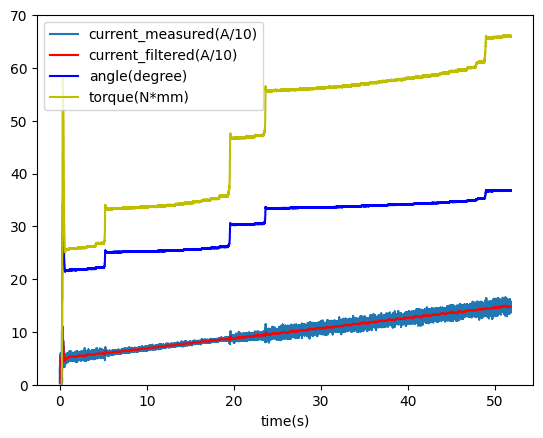

In [68]:

# alpha2=[]
# for alpha in alpha_seq:
#     tor_seq.append(get_torque(alpha))
#     alpha2.append(alpha*180/math.pi)
# plt.scatter(cur_seq,alpha2)
# plt.show()


all_angle_normalize=[]
all_tor=[]
for angle in all_angle:
    all_angle_normalize.append(angle*180/math.pi)
    all_tor.append(get_torque(angle)*1000)

fs=len(all_time)/100
print(fs)
y=lowpass_filter(all_cur,3,fs,4)
plt.plot(all_time,all_cur,label='current_measured(A/10)')
plt.plot(all_time,y,'r',label='current_filtered(A/10)')
plt.plot(all_time,all_angle_normalize,'b',label='angle(degree)')
plt.plot(all_time,all_tor,'y',label='torque(N*mm)')




plt.xlabel('time(s)')
plt.ylim(0,70)
plt.legend()
plt.show()


4
[6.000000000000001, 8.799999999999999, 9.599999999999996, 14.599999999999978] 
 [33.2939637050164, 46.181614818825636, 56.22023651239336, 65.12485763890788]


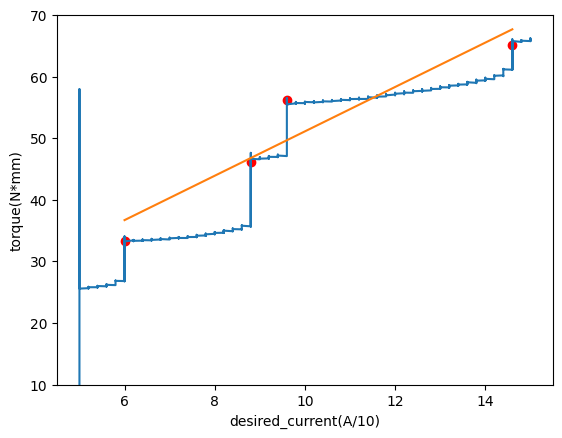

In [105]:

valid_tor=[]
valid_input=[]
saltation_flag=0
# therhold_seq=[28,36.5,48,62]
therhold_seq=[33,46,56,65]

for j in range(4):
    therhold=therhold_seq[j]
    for i in range(400,int(len(all_input))):
        if all_tor[i]>therhold:

            valid_tor.append(all_tor[i+1])
            valid_input.append(all_input[i+1])
            break

    
print(len(valid_input))

print(valid_input,'\n',valid_tor)

plt.plot(all_input,all_tor)
plt.xlabel('desired_current(A/10)')
plt.ylabel('torque(N*mm)')
# plt.xlim(5.9,6.2)
# plt.ylim(25,35)
plt.scatter(valid_input,valid_tor,color='red')
x=np.array(valid_input)
y=np.array(valid_tor)
parameter = np.polyfit(x, y, 1)
y2=parameter[0]*x+parameter[1]
plt.plot(x,y2)
plt.ylim(10,70)

plt.show()


for i in range(len(dif_cur_ini)):
    all_tor=[]
    angle_norm=[]
    for angle in angle_dif_ini[i]:
        all_tor.append(get_torque(angle)*1000)
        angle_norm.append(angle*180/math.pi)
    plt.plot(input_dif_ini[i],angle_norm,label='initial current= {} A/10'.format(dif_cur_ini[i]))
plt.xlabel('desired_current(A/10)')
plt.ylabel('angle(degree)')
plt.ylabel('torque(N*mm)')
plt.ylim(20,40)
plt.legend()
plt.show()

# TEST#2

make sure the crank is rotating very slowly to build a quati-static motion which friction is constant


In [ ]:
t0=time.monotonic()
print(type(t0))


In [ ]:
# TEST #1: 
t0=time.monotonic()
t00=t0

cur_seq=[]
current_last=0
desired_cur=5
stable_flag=0
alpha_seq=[]
angle_ini=0.055*2*math.pi #unit:rad

STATIC_SPEED_LOW=0.02 #unit rad/s
STATIC_SPEED_HIGH=0.2 #unit rad/s
CUR_STEP=0.02
TEST_PERIOD=10
CUR_LIMIT=20


all_cur=[0]
all_time=[0]
all_angle=[0]
all_input=[0]
all_vel=[]
run_flag=0
valid_cur=[]
valid_alpha=[]

while True:

    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured
    alpha=my_drive.axis1.encoder.pos_circular*2*math.pi-angle_ini
    vel=(alpha-all_angle[-1])*500 #frequency estimate to be 200Hz

    if vel<STATIC_SPEED_LOW:
        desired_cur+=CUR_STEP
        run_flag=0

    elif vel>STATIC_SPEED_HIGH and run_flag==0:#means the start moment 
        desired_cur=desired_cur-CUR_STEP
        run_flag=1
        valid_cur.append(current)
        valid_alpha.append(alpha)
        print('find a start moment with alpha={}'.format(alpha))

    all_time.append(delta)
    all_cur.append(current)
    all_angle.append(alpha)
    all_input.append(desired_cur)
    all_vel.append(vel)

    # time.sleep(0.02) #sanmple frequency= 100Hz

    if delta>TEST_PERIOD or desired_cur>CUR_LIMIT:
        break

my_drive.axis1.controller.input_torque=0
check(my_drive)
           


In [ ]:
print(len(valid_cur))
plt.scatter(valid_cur,valid_alpha)
plt.show()

In [ ]:
# tor_seq=[]
# alpha2=[]
# for alpha in alpha_seq:
#     tor_seq.append(get_torque(alpha))
#     alpha2.append(alpha*180/math.pi)
# plt.scatter(cur_seq,alpha2)
# plt.show()


all_angle_normalize=[]
for angle in all_angle:
    all_angle_normalize.append(angle*90/math.pi)
fs=len(all_time)/TEST_PERIOD
print(fs)
y=lowpass_filter(all_cur,3,fs,4)
plt.plot(all_time,all_cur,label='current_measured(A/10)')
plt.plot(all_time,y,'r',label='current_filtered(A/10)')
plt.plot(all_time,all_angle_normalize,'b',label='angle(degree*2)')
plt.plot(all_time,all_input,'y',label='desired_current(A/10)')

plt.xlabel('time(s)')
# plt.ylim(0,20)
plt.legend()
plt.show()



In [ ]:
my_drive.axis1.controller.input_torque=0
check(my_drive)

# TEST extra

increase each add bigger to make it not be stable due to static friction torque ;

and change the initial input to make the point more dense


In [ ]:
# TEST #1: 
t0=time.monotonic()


cur_seq=[]
current_last=0
desired_cur=5
stable_flag=0
alpha_seq=[]
angle_ini=0.055*2*math.pi #unit:rad
circle_num=1
add_num=0

while True:

    delta=time.monotonic()-t0
    my_drive.axis1.controller.input_torque=desired_cur
    current=my_drive.axis1.motor.current_control.Iq_measured

    if delta>3:
        t0=time.monotonic()
        alpha=my_drive.axis1.encoder.pos_circular*2*math.pi-angle_ini
        alpha_seq.append(alpha)
        cur_seq.append(current)
        desired_cur+=2
        add_num+=1
        print('detecting the stable current of {} A/10, angle is {}, and next GO TO {} A/10'.format(current,alpha,desired_cur))
    
    if add_num>5:
        my_drive.axis1.controller.input_torque = 0
        print('end the {} test circle'.format(circle_num))
        print('*'*50)
        time.sleep(2)
        desired_cur = 5+circle_num*0.5
        circle_num+=1
        add_num=0
        t0=time.monotonic()

    if circle_num>4:
        break

check(my_drive)
           


In [ ]:
tor_seq=[]
for alpha in alpha_seq:
    tor_seq.append(get_torque(alpha))

plt.scatter(cur_seq,tor_seq)
plt.show()
# fs=len(time_seq)/8
# cutoff=3
# print('sample frequency is',fs)
# y = lowpass_filter(current,cutoff,fs,4)


# plt.plot(time_seq,y,label='measured')
# plt.plot(time_seq,current_setpoint,label='setpoint')
# plt.legend()
# plt.show()


In [ ]:
check(my_drive)